In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                               ])

In [3]:
batch_size = 100
train_data = datasets.CIFAR10('data', train = True, download = True, transform = transform)
test_data = datasets.CIFAR10('data', train = False, download = True, transform= transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(dev_size * len(train_data)))
train_idx, dev_idx = idx[split_size:], idx[:split_size]


In [5]:
train_sampler = SubsetRandomSampler(train_idx)
dev_sampler = SubsetRandomSampler(dev_idx)

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = dev_sampler )
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [7]:
class CNN(nn.Module):
    def __init__(self):
      super(CNN,self).__init__()
      self.conv1 = nn.Conv2d(3,10,3,1,1)
      self.conv2 = nn.Conv2d(10,20,3,1,1)
      self.conv3 = nn.Conv2d(20,40,3,1,1)
      self.pool = nn.MaxPool2d(2,2)
      self.dropout = nn.Dropout(0.2)
      self.linear1 = nn.Linear(40*4*4, 100)
      self.linear2 = nn.Linear(100,10)

    def forward(self,x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = x.view(-1,40*4*4)
      x = self.dropout(x)
      x = F.relu(self.linear1(x))
      x = self.dropout(x)
      x = F.log_softmax(self.linear2(x), dim=1)
      return x


In [8]:
model = CNN().to("cuda")
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 50

In [9]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []
for e in range(1, epochs+1):
    losses = 0
    acc = 0
    iterations = 0
    
    model.train()
    for data, target in train_loader:
        iterations += 1
        pred = model(data.to("cuda"))
        loss = loss_function(pred, target.to("cuda"))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()
        p = torch.exp(pred)
        top_p, top_class = p.topk(1, dim=1)
        acc += accuracy_score(target.to("cpu"), top_class.to("cpu"))
    dev_losss = 0
    dev_accs = 0
    iter_2 = 0
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        with torch.no_grad():
            model.eval()
            for data_dev, target_dev in dev_loader:
                iter_2 += 1
                dev_pred = model(data_dev.to("cuda"))
                dev_loss = loss_function(dev_pred, target_dev.to("cuda"))
                dev_losss += dev_loss.item()
                dev_p = torch.exp(dev_pred)
                top_p, dev_top_class = dev_p.topk(1, dim=1)
                dev_accs += accuracy_score(target_dev.to("cpu"), dev_top_class.to("cpu"))
        train_losses.append(losses/iterations)
        dev_losses.append(dev_losss/iter_2)
        train_acc.append(acc/iterations)
        dev_acc.append(dev_accs/iter_2)
        print("Epoch: {}/{}.. ".format(e, epochs), 
              "Training Loss: {:.3f}.. ".format(losses/iterations), 
              "Validation Loss: {:.3f}.. ".format(dev_losss/iter_2), 
              "Training Accuracy: {:.3f}.. ".format(acc/iterations), 
              "Validation Accuracy: {:.3f}".format(dev_accs/iter_2))

Epoch: 1/50..  Training Loss: 1.770..  Validation Loss: 1.496..  Training Accuracy: 0.352..  Validation Accuracy: 0.454
Epoch: 5/50..  Training Loss: 1.181..  Validation Loss: 1.087..  Training Accuracy: 0.576..  Validation Accuracy: 0.608
Epoch: 10/50..  Training Loss: 0.986..  Validation Loss: 0.955..  Training Accuracy: 0.649..  Validation Accuracy: 0.663
Epoch: 15/50..  Training Loss: 0.864..  Validation Loss: 0.911..  Training Accuracy: 0.693..  Validation Accuracy: 0.678
Epoch: 20/50..  Training Loss: 0.794..  Validation Loss: 0.871..  Training Accuracy: 0.716..  Validation Accuracy: 0.690
Epoch: 25/50..  Training Loss: 0.740..  Validation Loss: 0.849..  Training Accuracy: 0.736..  Validation Accuracy: 0.705
Epoch: 30/50..  Training Loss: 0.699..  Validation Loss: 0.848..  Training Accuracy: 0.747..  Validation Accuracy: 0.705
Epoch: 35/50..  Training Loss: 0.672..  Validation Loss: 0.837..  Training Accuracy: 0.760..  Validation Accuracy: 0.716
Epoch: 40/50..  Training Loss: 0.6

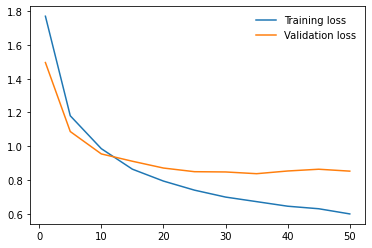

In [10]:
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

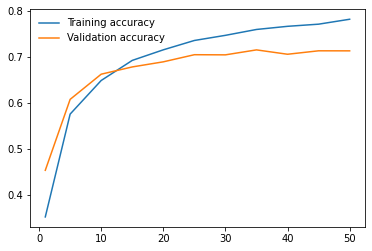

In [11]:
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [13]:
model.eval()
iter_3 = 0
acc_test = 0
for data_test, target_test in test_loader:
    iter_3 += 1
    test_pred = model(data_test.to("cuda"))
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    acc_test += accuracy_score(target_test .to("cpu"), top_class_test .to("cpu"))
print(acc_test/iter_3)

0.7097999999999998
